<a href="https://colab.research.google.com/github/RezJalali/CMCT-course-content/blob/main/tutorials/W1D3_RemoteSensing/student/W1D3_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W1D3_RemoteSensing/student/W1D3_Tutorial3.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W1D3_RemoteSensing/student/W1D3_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: Visualizing Satellite CDR - Global Vegetation Mapping

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Paul Heubel, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Paul Heubel, Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Paul Heubel, Jenna Pearson, Konstantine Tsafatinos, Chi Zhang, Ohad Zivan

**Our 2024 Sponsors:** CMIP, NFDI4Earth

# Tutorial Objectives

*Estimated timing of tutorial:* 25 minutes

In this tutorial, you will acquire the skills necessary for accessing and analyzing satellite remote sensing products, particularly in the context of climate applications. We will be using vegetation mapping as an example, and use long-term vegetation greenness data to demonstrate these skills.

By the end of this tutorial you will be able to:

* Locate, access, and visualize vegetation greenness data (NDVI) from the cloud using `xarray` and `matplotlib`.
* Understand how to use quality flag information included in the datasets to filter out data that is not acceptable to use for climate analysis.


# Setup

In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

!pip install s3fs --quiet

# properly install cartopy in colab to avoid session crash
!apt-get install libproj-dev proj-data proj-bin --quiet
!apt-get install libgeos-dev --quiet
!pip install cython --quiet
!pip install cartopy --quiet

!apt-get -qq install python-cartopy python3-cartopy  --quiet
!pip uninstall -y shapely  --quiet
!pip install shapely --no-binary shapely  --quiet

!pip install boto3 --quiet

# you may need to restart the runtime after running this cell and that is ok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 46.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires n

In [2]:
# imports
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import boto3
import botocore
import pooch
import os
import tempfile

In [3]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "comptools_4clim",
            "user_key": "l5jpxuee",
        },
    ).render()


feedback_prefix = "W1D3_T3"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00


In [4]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle"
)

In [5]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/data/tutorials/W1D3_RemoteSensing"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [6]:
# @title Video 1: Access and Visualize Satellite CDR

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'y5l1o3FGbCw'), ('Bilibili', 'BV1tF41197Lv')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [7]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Access_Visualize_Satellite_CDR_Video")

In [8]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "g9n5d"

print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/g9n5d/


In [9]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Access_Visualize_Satellite_CDR_Slides")

# Section 1: Satellite Monitoring of Vegetation Status

As we learned in the previous tutorial, all the **National Atmospheric and Oceanic Administration Climate Data Record (NOAA-CDR)** datasets are available both at NOAA National Centers for Environmental Information (NCEI) and commercial cloud platforms. Here, we are accessing the data directly via the **Amazon Web Service (AWS)**. You can get more information about the NOAA CDRs on AWS's Open Data Registry.

* [NOAA Fundamental CDR on AWS](https://registry.opendata.aws/noaa-cdr-fundamental/)
* [NOAA Terrestrial CDR on AWS](https://registry.opendata.aws/noaa-cdr-terrestrial/)
* [NOAA Atmospheric CDR on AWS](https://registry.opendata.aws/noaa-cdr-atmospheric/)
* [NOAA Oceanic CDR on AWS](https://registry.opendata.aws/noaa-cdr-oceanic/)

The index we will use in this tutorial is the **Normalized Difference Vegetation Index (NDVI)**.  It is one of the most commonly used remotely sensed indices. It measures the "greenness" of vegetation and is useful in understanding vegetation density and assessing changes in plant health. For example, NDVI can be used to study the impact of drought, heat waves, and insect infestation on plants covering Earth's surface. One sensor that can provide such data is the ***Visible and Infrared Imager/
Radiometer Suite VIIRS***. It is one of five instruments onboard the Suomi National Polar-orbiting Partnership (SNPP) satellite platform that was launched on October 28, 2011.

## Section 1.1: Access NOAA NDVI CDR Data from AWS



If we go to the [cloud storage space (or a S3 bucket)](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/) that hosts NOAA NDVI CDR data, you will see the pattern of how the NOAA NDVI CDR is organized:

`s3://noaa-cdr-ndvi-pds/data/2022/VIIRS-Land_v001_NPP13C1_S-NPP_20220101_c20240126162652.nc`

We can take advantage of the pattern to search for the data file systematically.

> Parent directory: `s3://noaa-cdr-ndvi-pds/data/`
> Sub-directory for each year: `2022/`
> File name of each day: `VIIRS-Land_v001_NPP13C1_S-NPP_20220101_c20240126162652.nc`

The file name also has a clear pattern:

> Sensor name: `VIIRS`  
> Product category: `Land`  
> Product version: `v001`
> Product type: `NPP13C1`  (*JP113C1 in 2024, so dependent on the satellite era*)
> Satellite platform: `S-NPP`  (*NOAA-20 in 2024, so dependent on the satellite era*)
> Date of the data: `20220101`  
> Processing time: `c20240126162652` (*This will change for each file based on when the file was processed*)  
> File format: `.nc` (*netCDF-4 format*)

In other words, if we are looking for the data of a specific day, we can easily locate where the file might be.

Note that the above example data is from 2022, measurements from 2024 are very new, which is why there it was called `v001-preliminary` before. Quality control often leads to changes in the naming and availability. So be prepared that you have to check the data tree of your source regularly.

For example, if we now want to find the VIIRS data for the day of *2014-03-12 (or March 12, 2014)*, you can use:

`s3://noaa-cdr-ndvi-pds/data/2014/VIIRS-Land_v001_NPP13C1_*_20140312_c*.nc`

You see, we do not need a `preliminary` tag, as the `2014` data passed quality control already.

The reason that we put `*` in the above directory is that we are not sure about what satellite platform this data is from and when the data was processed. The `*` is called a **wildcard**, and is used because we want *all* the files that contain our specific criteria, but do not want to have to specify all the other pieces of the filename we are not sure about yet. It should return all the data satisfying that initial criteria and you can refine further once you see what is available. Essentially, this first step helps to narrow down the data search.

For a detailed description of the file name identifiers, check out this resource: [Chapter 3.4.7 of the VIIRS Surface Reflectance and Normalized Difference Vegetation Index - Climate Algorithm Theoretical Basis Document, NOAA Climate Data Record Program CDRP-ATBD-1267 Rev. 0
(2022). Available at https://www.ncei.noaa.gov/products/climate-data-records](https://www.ncei.noaa.gov/pub/data/sds/cdr/CDRs/Normalized_Difference_Vegetation_Index/VIIRS/AlgorithmDescriptionVIIRS_01B-20b.pdf).

In [10]:
# to access the NDVI data from AWS S3 bucket, we first need to connect to s3 bucket
fs = s3fs.S3FileSystem(anon=True)

# we can now check to see if the file exist in this cloud storage bucket using the file name pattern we just described
date_sel = datetime.datetime(
    2014, 3, 12, 0
)  # select a desired date and hours (midnight is zero)

# automatic filename from data_sel. we use strftime (string format time) to get the text format of the file in question.
file_location = fs.glob(
    "s3://noaa-cdr-ndvi-pds/data/"
    + date_sel.strftime("%Y")
    + "/VIIRS-Land_v001_NPP13C1_S-NPP_*"
    + date_sel.strftime("%Y%m%d")
    + "_c*.nc"
)
# now let's check if there is a file that matches the pattern of the date that we are interested in.
file_location
# VIIRS-Land_v001_NPP13C1_S-NPP_20240312_c20240304220534.nc

['noaa-cdr-ndvi-pds/data/2014/VIIRS-Land_v001_NPP13C1_S-NPP_20140312_c20240304220534.nc']

### Coding Exercises 1.1

1. NDVI CDR data switched sensors on 2014 from AVHRR (the older generation sensor) to VIIRS (the newest generation sensor). Using the code above and the [list of data names](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/) for VIIRS, find data from a day of another year than 2014 or 2024. You will need to modify string input into `glob()` to do so.

In [11]:
# select a desired date and hours (midnight is zero)
exercise_date_sel = datetime.datetime(2016,8,15,12)

# automatic filename from data_sel. we use strftime (string format time) to get the text format of the file in question.
exercise_file_location = fs.glob(
        "s3://noaa-cdr-ndvi-pds/data/"
    + exercise_date_sel.strftime("%Y")
    + "/VIIRS-Land_v001_NPP13C1_S-NPP_*"
    + exercise_date_sel.strftime("%Y%m%d")
    + "_c*.nc"
)

# now let's check if there is a file that matches the pattern of the date that we are interested in.
exercise_file_location

['noaa-cdr-ndvi-pds/data/2016/VIIRS-Land_v001_NPP13C1_S-NPP_20160815_c20240125053929.nc']

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W1D3_RemoteSensing/solutions/W1D3_Tutorial3_Solution_0726ff4a.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercise_1_1")

## Section 1.2: Read NDVI CDR Data

Now that you have the location of the NDVI data for a specific date, you can read in the data using the python library `xarray` to open the [netCDF-4 file](https://pro.arcgis.com/en/pro-app/latest/help/data/multidimensional/what-is-netcdf-data.htm), a common data format used to store satellite and climate datasets.



In [12]:
# first, we need to open the connection to the file object of the selected date.
# we are still using the date of 2014-03-12 as the example here.

# to keep up with previous tutorials (consistency), we are going to use boto3 and pooch to open the file.
# but note s3fs also has the ability to open files from s3 remotely.

client = boto3.client(
    "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
)  # initialize aws s3 bucket client

ds = xr.open_dataset(
    pooch_load(
        filelocation="http://s3.amazonaws.com/" + file_location[0],
        filename=file_location[0],
    ),
    decode_times=False # to address overflow issue
)  # open the file
ds

SHA256 hash of downloaded file: 6496fa2f509615a802897f798472c9a306d16030aede35d8b4f2233e2987a05b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


<xarray.Dataset> Size: 467MB
Dimensions:    (latitude: 3600, longitude: 7200, time: 1, ncrs: 1, nv: 2)
Coordinates:
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) float32 4B 1.212e+04
Dimensions without coordinates: ncrs, nv
Data variables:
    crs        (ncrs) int16 2B ...
    lat_bnds   (latitude, nv) float32 29kB ...
    lon_bnds   (longitude, nv) float32 58kB ...
    NDVI       (time, latitude, longitude) float64 207MB ...
    TIMEOFDAY  (time, latitude, longitude) float64 207MB ...
    QA         (time, latitude, longitude) int16 52MB ...
Attributes: (12/44)
    title:                             Normalized Difference Vegetation Index...
    institution:                       NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-LAND ...
    Conventions:                       CF-1.6, ACDD-1.3
    standard_name_vocabulary:          CF Standard Name Table (v25, 05 July 2...
    naming_authority:                  gov.noaa.ncei
    license:                           See the Use Agreement for this CDR ava...
    ...                                ...
    LocalGranuleID:                    VIIRS-Land_v002_NPP13C1_S-NPP_20140312...
    id:                                VIIRS-Land_v002_NPP13C1_S-NPP_20140312...
    RangeBeginningDate:                2014-03-12
    RangeBeginningTime:                00:00:00.0000
    RangeEndingDate:                   2014-03-12
    RangeEndingTime:                   23:59:59.9999

The output from the code block tells us that the NDVI data file of 2014-03-12 has dimensions of `3600x7200`. This makes sense for a dataset with a spatial resolution of 0.05°×0.05° that spans 180° of latitude and 360° of longitude. There is another dimension of the dataset named `time`. Since it is a daily data file, it only contains one value.

Two main data variables in this dataset are `NDVI` and `QA`.

* `NDVI` is the variable that contains the value of Normalized Difference Vegetation Index  (NDVI - ranges between -1 and 1) that can be used to measure the vegetation greenness.  
* `QA` is the variable that indicates the quality of the NDVI values for each corresponding grid. It reflects whether the data is of high quality or should be discarded because of various reasons (e.g., bad sensor data, potentially contaminated by clouds).



## Section 1.3: Visualize NDVI CDR Data

In [13]:
# examine NDVI values from the dataset
ndvi = ds.NDVI
ndvi

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)> Size: 207MB
[25920000 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) float32 4B 1.212e+04
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

To visualize the raw data, we will will plot it using `matplotlib` by calling `.plot()` on our xarray `DataArray`.

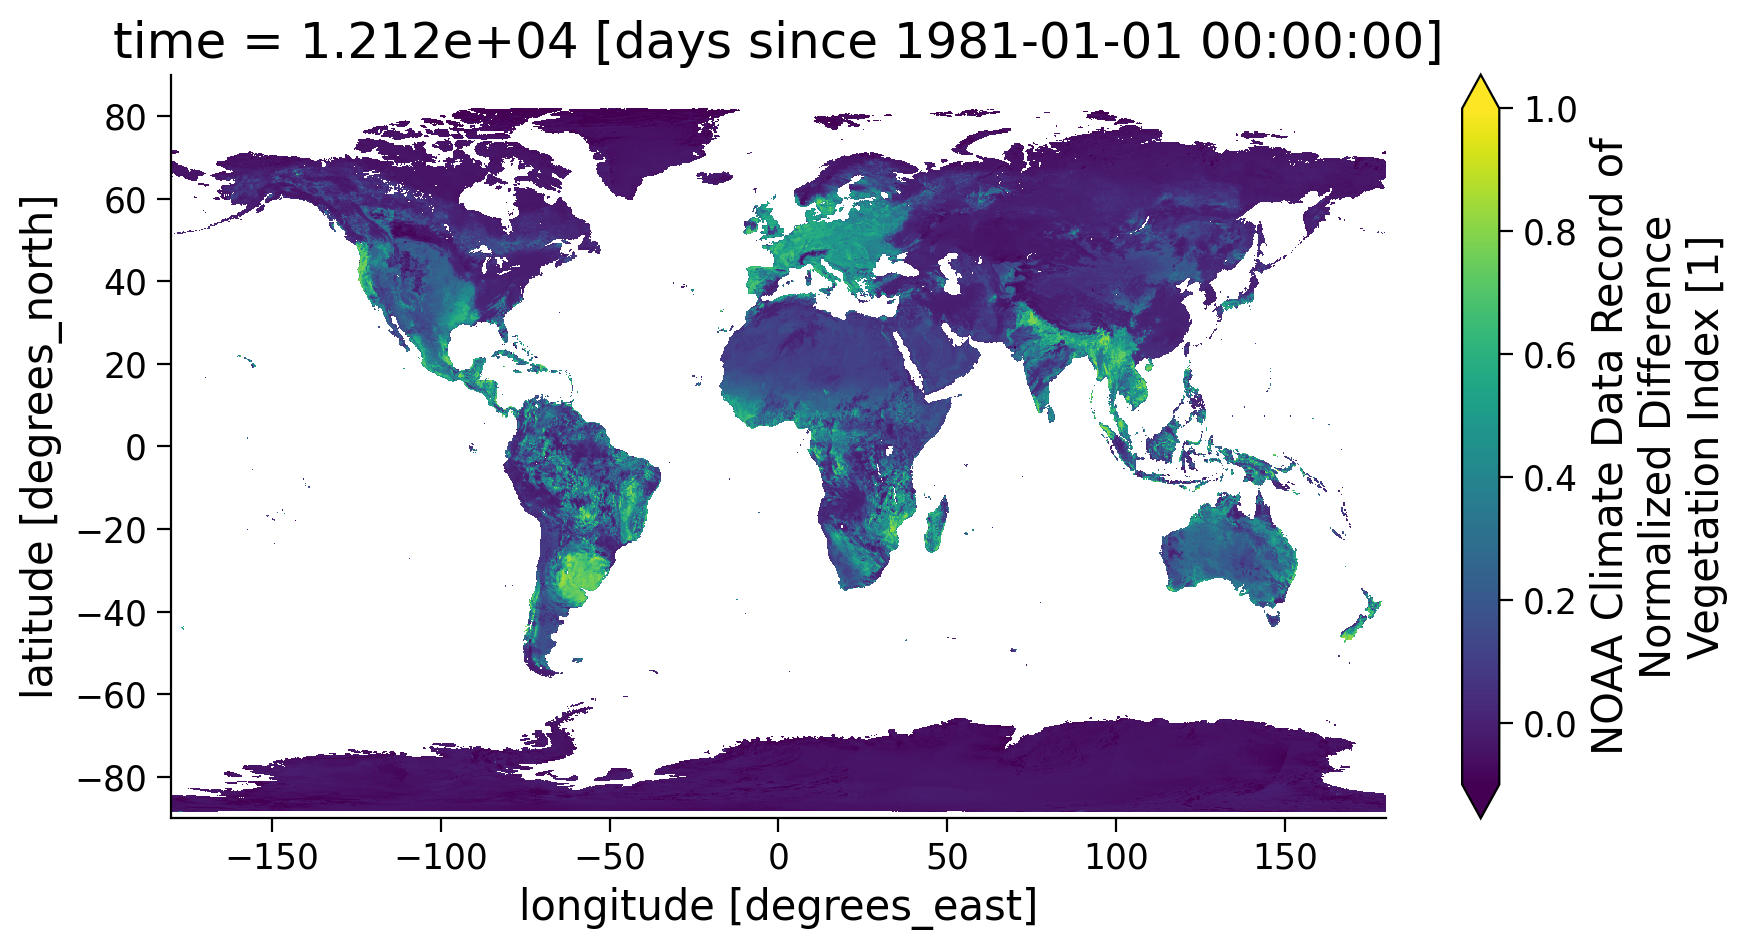

In [14]:
# figure settings:
# vmin & vmax: minimum and maximum values for the colorbar
# aspect: setting the aspect ratio of the figure, must be combined with `size`
# size: setting the overall size of the figure

# to make plotting faster and less memory intensive we use coarsen to reduce the number of pixels
ndvi.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(
    vmin=-0.1,
    vmax=1.0,
    aspect=1.8,
    size=5
)

## Section 1.4: Mask NDVI Data Using a Quality Flag

As stated earlier, there is also a variable `QA` that indicates the quality of the NDVI value for each grid cell. This quality information is very important when using satellite data to ensure the climate analysis is done using only the highest quality data.

For NDVI CDR data, it has a complex quality flag system that is represented using a 16-bit system. Although when you explore the values of `QA`, it appears to be normal numeric values, the QA value needs to be converted to binary values of 16 bits and recognize the quality flag based on the information listed in the table below.

 Bit Number | Parameter Name | Bit Combination | Description |
|-:|:-|:-:|:-:|
| 0-1        | Cloud State             | 00 | Confident Clear |
|            |                         | 01 | Probably Clear  |
|            |                         | 10 | Probably Cloudy |
|            |                         | 11 | Confident Cloudy|
| 2          | Cloud shadow            | 1  | Yes             |
|            |                         | 0  | No              |
| 3-5        | Land/Water flag         | 000 | Land & Desert  |
|            |                         | 001 | Land no desert |
|            |                         | 010 | Inland Water   |
|            |                         | 011 | Sea Water      |
|            |                         | 100 | \---           |
|            |                         | 101 | Coastal        |
|            |                         | 110 | \---           |
|            |                         | 111 | \---           |
| 6          | Overall Aerosol Quality | 1   | OK             |
|            |                         | 0   | Poor           |
| 7          | Unused                  | \---| \---           |
| 8          | Thin cirrus reflective  | 1   | Yes            |
|            |                         | 0   | No             |
| 9          | Thin cirrus emissive    | 1   | Yes            |
|            |                         | 0   | No             |
| 10         | Cloud flag              | 1   | Cloud          |
|            |                         | 0   | No cloud       |
| 11-14      | Unused                  | \---| \---           |
| 15         | Snow/Ice Flag           | 1   | Snow/Ice       |
|            |                         | 0   | No snow/Ice    |

([Table 7, Chapter 4.3 of algorithm documentation (Climate Algorithm Theoretical Basis Document (C-ATBD)](https://www.ncei.noaa.gov/pub/data/sds/cdr/CDRs/Normalized_Difference_Vegetation_Index/VIIRS/AlgorithmDescriptionVIIRS_01B-20b.pdf))

This shows the complex system to ensure that satellite CDR data is of high quality for climate applications. But how can we decipher the quality of a given pixel?

Assuming that we have a grid with `QA=8` when converted into a binary value with the length of 16 bits it becomes `0000000000001000`. That is, every `QA` value will be converted into a list of 1's and 0's that is 16 numbers long. Converting our example above of 8 we have:

|Bit15|Bit14|Bit13|Bit12|Bit11|Bit10|Bit9|Bit8|Bit7|Bit6|Bit5|Bit4|Bit3|Bit2|Bit1|Bit0|
|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|
|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0|0|
|No|No|No|No|No|No|No|No|No|No|No|No|Yes|No|No|No|

Note here that 1 is `True` and 0 is `False`. Interpreting the table above, for a quality flag of 8, VIIRS channels (`Bit3=1`), (`Bit4=0`), and (`Bit5=0`) tell that the grid cell is over land that is not desert. The (`Bit0=0`) and  (`Bit1=0`) as well as (`Bit1=10`) flags confidently confirm a clear sky. Therefore, the QA tells us that we can use this grid since it is not covered by clouds and vegetation information on the land surface is reflected.

If you are a little confused by how to convert to binary, that is ok! This is a skill that you can practice more in your projects. For this tutorial, we will define a function that will automate our selection process to avoid cloudy data.

In [15]:
# define a function to extract high-quality NDVI data from a VIIRS data set
def get_quality_info(QA):
    """
    QA: the QA value read in from the NDVI data

    High-quality NDVI should meet the following criteria:
    Bit 10: 0 (There were no clouds detected)
    Bit 2: 0 (The pixel is not covered by cloud shadow)
    Bit 0 and Bit 1: 00 (The pixel confidently has a clear sky)

    Output:
    True: high quality
    False: low quality
    """
    # unpack quality assurance flag for cloud (byte: 0)
    cld_flag0 = (QA % (2**1)) // 2**0
    # unpack quality assurance flag for cloud (byte: 1)
    cld_flag1 = (QA % (2**2)) // 2
    # unpack quality assurance flag for cloud shadow (byte: 2)
    cld_shadow = (QA % (2**3)) // 2**2
    # unpack quality assurance flag for cloud values (byte: 10)
    cld_flag10 = (QA % (2**11)) // 2**10

    mask = (cld_flag0 == 0) & (cld_flag1 == 0) & (cld_shadow == 0) & (cld_flag10 == 0)

    return mask

You also might come across some NDVI data that was sensed by VIIRS' predecessor sensor: the Advanced Very High Resolution Radiometer (AVHRR). As the quality info differs from VIIRS, the following cell provides a function to extract high-quality data from such a data set. We provide it here for the sake of completeness, you do not have to execute its cell.

In [ ]:
# @markdown AVHRR: function to extract high-quality NDVI data
def get_quality_info_AVHRR(QA):
    """
    QA: the QA value read in from the NDVI data

    High-quality NDVI should meet the following criteria:
    Bit 7: 1 (All AVHRR channels have valid values)
    Bit 2: 0 (The pixel is not covered by cloud shadow)
    Bit 1: 0 (The pixel is not covered by cloud)
    Bit 0:

    Output:
    True: high quality
    False: low quality
    """
    # unpack quality assurance flag for cloud (byte: 1)
    cld_flag = (QA % (2**2)) // 2
    # unpack quality assurance flag for cloud shadow (byte: 2)
    cld_shadow = (QA % (2**3)) // 2**2
    # unpack quality assurance flag for AVHRR values (byte: 7)
    value_valid = (QA % (2**8)) // 2**7

    mask = (cld_flag == 0) & (cld_shadow == 0) & (value_valid == 1)

    return mask

In [16]:
# get the quality assurance value from NDVI data
QA = ds.QA

# create the high quality information mask
mask = get_quality_info(QA)

# check the quality flag mask information
mask

<xarray.DataArray 'QA' (time: 1, latitude: 3600, longitude: 7200)> Size: 26MB
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) float32 4B 1.212e+04

The output of the previous operation gives us a data array with logical values to indicate if a grid has high quality NDVI values or not. Now let's mask out the NDVI data array with this quality information to see if this will make a difference in the final map.

In [17]:
# use `.where` to only keep the NDVI values with high quality flag
ndvi_masked = ndvi.where(mask)
ndvi_masked

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)> Size: 207MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * latitude   (latitude) float32 14kB 89.97 89.93 89.88 ... -89.93 -89.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) float32 4B 1.212e+04
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

As you may have noticed, a lot of the NDVI values in the masked data array becomes `nan` which means `not a number`. This means that the grid does not have a high quality NDVI value based on the QA value. Now, let's plot the map one more time to see the difference after the quality masking.

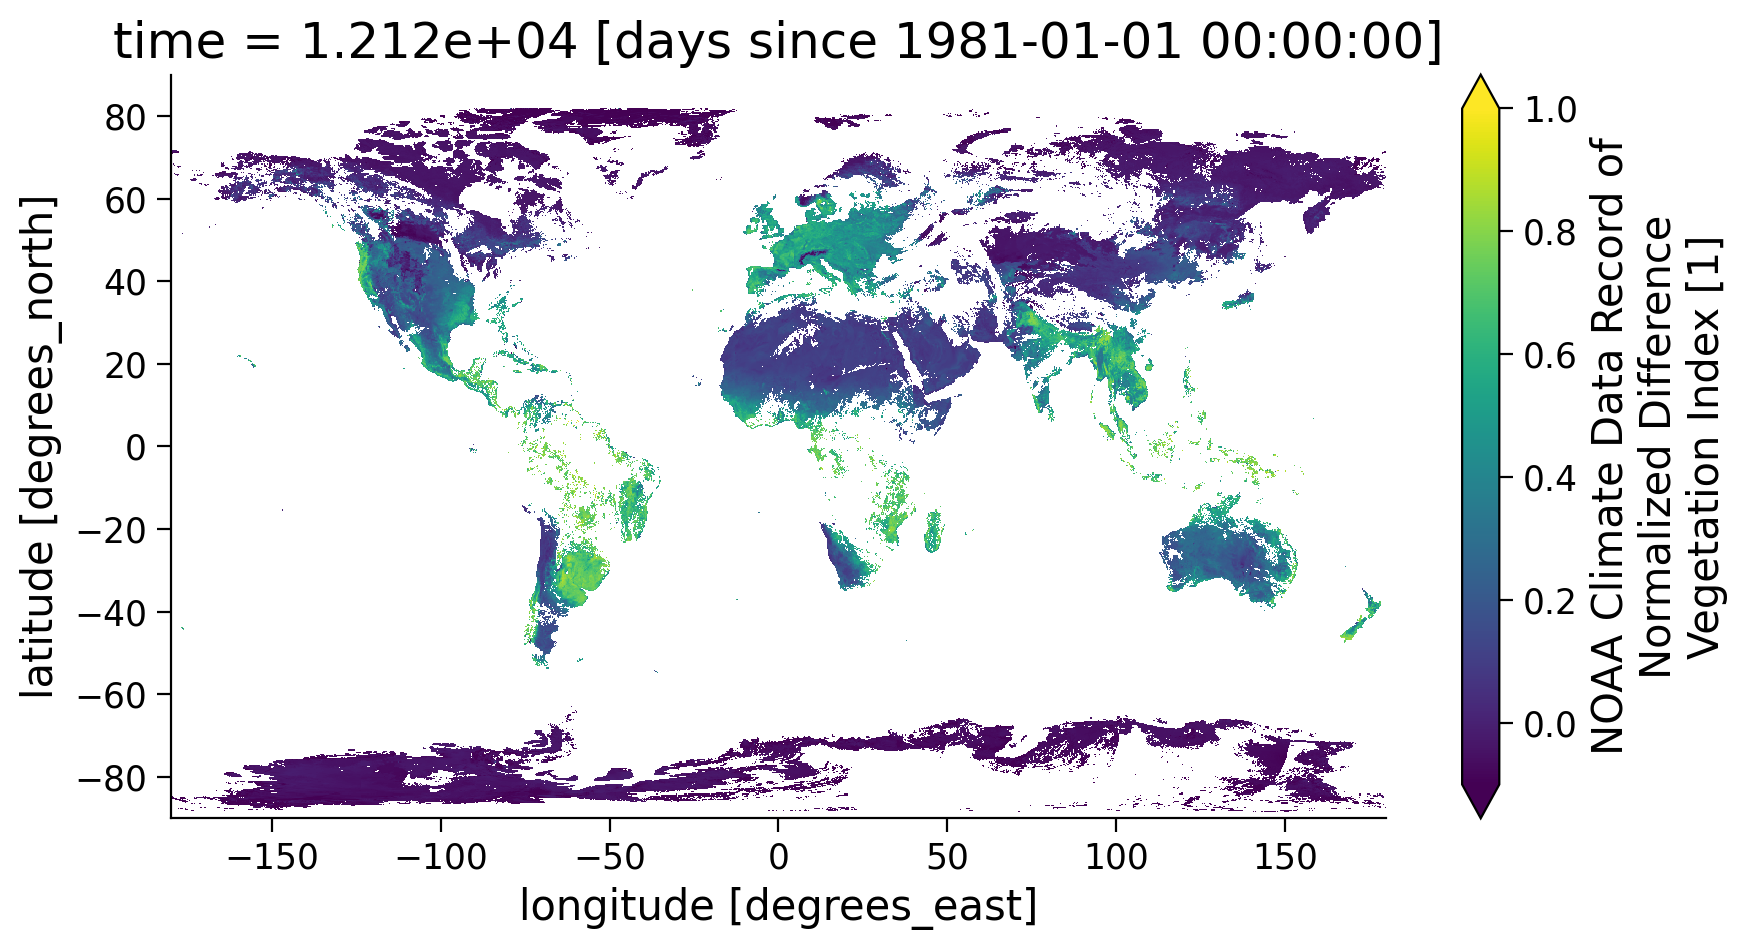

In [18]:
# re-plot the NDVI map using masked data
ndvi_masked.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(
    vmin=-0.1, vmax=1.0, aspect=1.8, size=5
)

Note the large difference after the quality mask was applied and you removed data that was compromised due to clouds. Since the NDVI value is calculated using the reflectance values of the red and near-infrared spectral band, this value is only useful for vegetation and surface monitoring when there are no clouds present. Thus, we always need to remove the grid with clouds in the data.

### Coding Exercises 1.4

You just learned how to use `xarray` and `matplotlib` to access NDVI CDR data from AWS and visualize it. Can you find a different date that you are interested in and visualize the high quality NDVI data of that day? Note the solution is just an example of a date that you could choose.

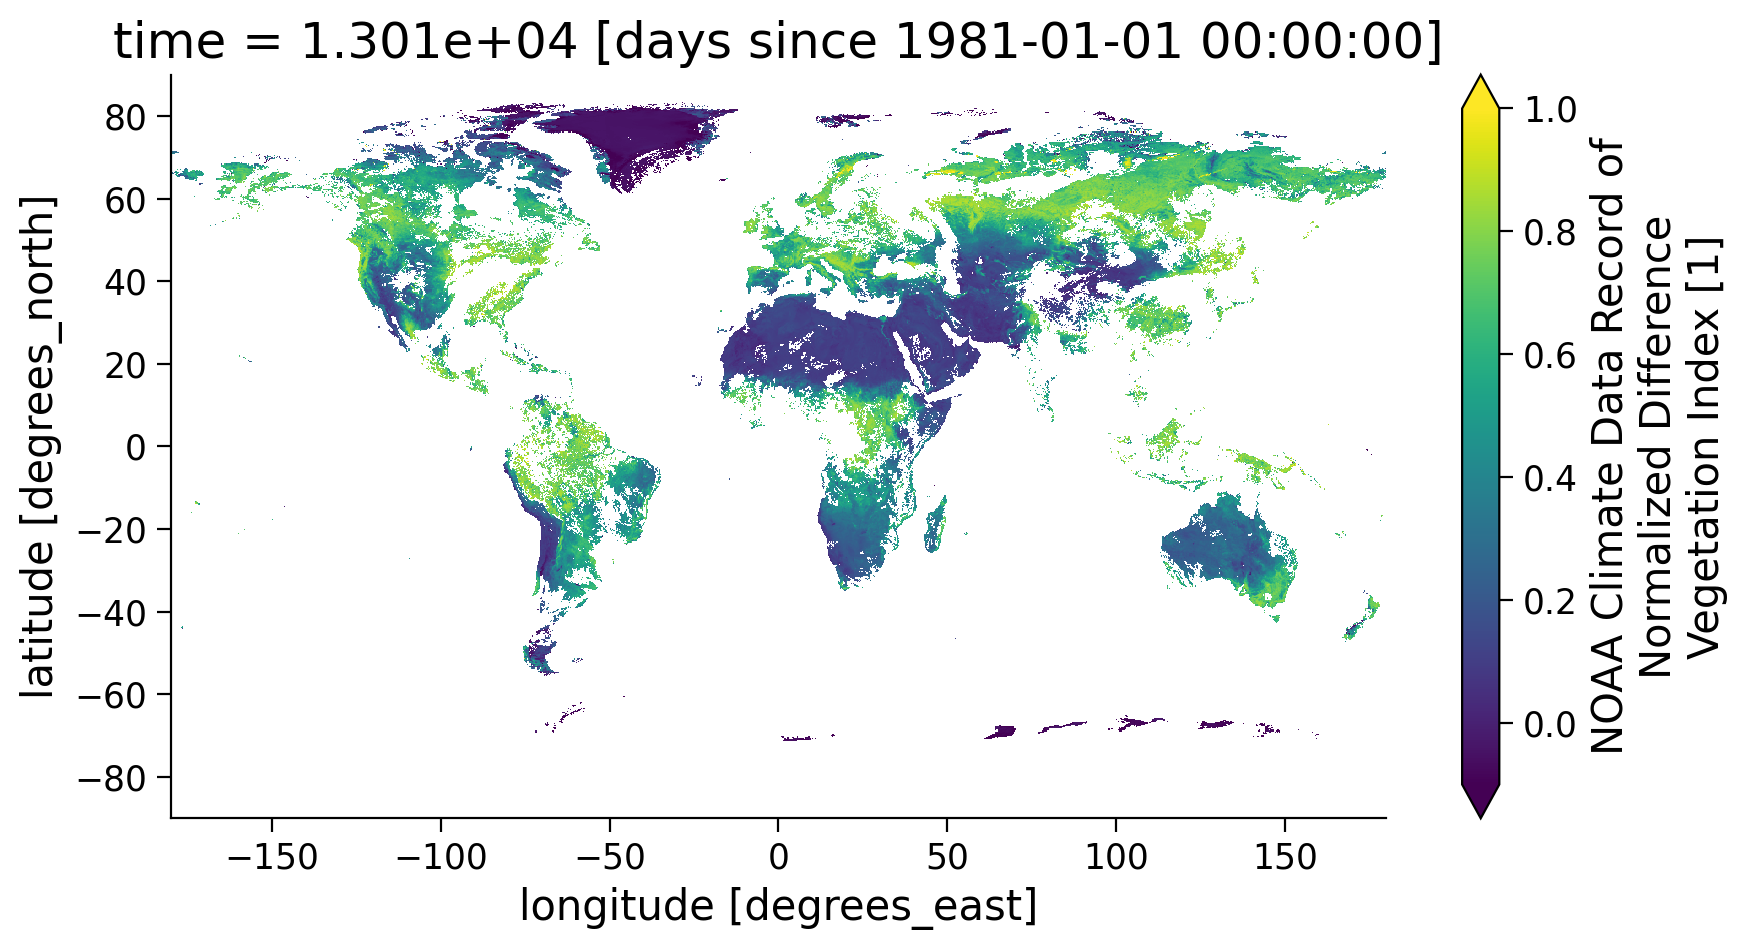

In [20]:
# define the date of your interest YYYYMMDD (e.g., 20030701)
# select a desired date and hours (midnight is zero)
date_sel_exercise = datetime.datetime(2016,8,15,12)

# locate the data in the AWS S3 bucket
# hint: use the file pattern that we described
file_location_exercise =  fs.glob("s3://noaa-cdr-ndvi-pds/data/"
    + date_sel_exercise.strftime("%Y")
    + "/VIIRS-Land_v001_NPP13C1_S-NPP_*"
    + date_sel_exercise.strftime("%Y%m%d")
    + "_c*.nc")

# open file connection to the file in AWS S3 bucket and use xarray to open the NDVI CDR file
# open the file
client = boto3.client(
    "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
)  # initialize aws s3 bucket client

ds_exercise = xr.open_dataset(
    pooch_load(
        filelocation="http://s3.amazonaws.com/" + file_location_exercise[0],
        filename=file_location_exercise[0],
    ),
    decode_times=False # to address overflow issue
)  # open the file
NDVI_data = ds_exercise.NDVI
QA = ds_exercise.QA


mask = get_quality_info(QA)
masked_data = NDVI_data.where(mask)
masked_data.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(
    vmin=-0.1,
    vmax=1.0,
    aspect=1.8,
    size=5
)
# get the QA value and extract the high quality data mask and Mask NDVI data to keep only high quality value
# hint: reuse the get_quality_info helper function we defined
# ndvi_masked_exercise = ...

# plot high quality NDVI data
# hint: use plot() function
# ndvi_masked_exercise.coarsen(latitude=5).mean().coarsen(longitude=5).mean().plot(
#     vmin=-0.1, vmax=1.0, aspect=1.8, size=5
# )

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W1D3_RemoteSensing/solutions/W1D3_Tutorial3_Solution_509be09f.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_Exercise_1_4")

# Summary

In this tutorial, you successfully accessed and visualized one of the most commonly used remotely sensed climate datasets for land applications! In addition, you should now:

* Understand the file organization pattern to help you identify the data that you are interested in.
* Understand how to extract only the high-quality data using quality flags provided with the datasets.
* Know how to apply a quality flag mask and plot the resulting data.

In the next tutorial, you will explore how to perform time series analysis, including calculating climatologies and anomalies with precipitation data.

# Resources

Data from this tutorial can be accessed [here](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/).